# Head Pose Estimation with AFLW2000 Dataset
### Analyzing and Visualizing Head Pose Angles

**Introduction:**  
In this notebook, we will load images and corresponding head pose parameters from the AFLW2000 dataset, process them, and visualize the feature points to understand head orientation. This work is essential in applications such as head pose estimation. We will also define key functions for efficient data loading and visualization.

### Library Imports
- **mediapipe**: Used for facial and landmark detection.
- **OpenCV (cv2)**: Image processing library.
- **NumPy**: Handles array-based computations.
- **Pandas**: For data manipulation.
- **Matplotlib**: For visualizations.
- **glob**: For finding files by pattern matching.
- **SciPy**: Specifically, `scipy.io` to load `.mat` files containing pose data.

In [31]:
# Import necessary libraries
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.io

## Data Loading and Processing Functions
Below we define functions to load image and pose data, allowing for streamlined data handling.

In [32]:
# Function 1: Load and Display Dataset Information
def load_image_and_pose(img_idx, img_dir='./AFLW2000/', mat_ext='.mat', img_ext='.jpg'):
    """
    Loads an image and its corresponding pose parameters from the AFLW2000 dataset.
    
    Parameters:
    - img_idx: Index of the image to load.
    - img_dir: Directory path where the dataset images and .mat files are stored.
    - mat_ext: Extension of the .mat file (default is '.mat').
    - img_ext: Extension of the image file (default is '.jpg').
    
    Returns:
    - img: Loaded image in RGB format.
    - pitch, yaw, roll: Head pose angles (in radians).
    """
    try:
        # Get paths of the image and corresponding .mat file
        img_paths = glob.glob(f'{img_dir}*{img_ext}')
        mat_paths = glob.glob(f'{img_dir}*{mat_ext}')
        
        # Load image
        img = cv2.imread(img_paths[img_idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load pose parameters from .mat file
        mat = scipy.io.loadmat(mat_paths[img_idx])
        pitch, yaw, roll = mat['Pose_Para'][0][:3]
        
        return img, pitch, yaw, roll
    except IndexError:
        raise FileNotFoundError("Image or corresponding .mat file not found for the given index.")
    except Exception as e:
        raise RuntimeError(f"Error loading data: {e}")

## Image Display Function
This function, `display_image`, enables visualization of images within the notebook, with customizable title and figure size options to enhance image analysis.

In [33]:
# Function 2: Display an Image
def display_image(img, title="Image", figsize=(20, 10)):
    """
    Displays the provided image using matplotlib.
    
    Parameters:
    - img: Image array to display.
    - title: Title for the plot.
    - figsize: Size of the plot figure.
    """
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(img)
    plt.show()

## Face Landmark Detection and Nose Positioning
The `detect_face_landmarks` function uses MediaPipe's face mesh model to identify facial landmarks on an image, focusing on extracting the nose coordinates. The function also provides an annotated version of the image with facial landmarks highlighted, facilitating visualization and precise nose position retrieval for further processing.

In [34]:
# Function 3: Detect Face Landmarks and Draw Face Mesh
def detect_face_landmarks(img):
    """
    Detects facial landmarks using MediaPipe's face mesh and returns the nose position,
    along with an image that shows the face mesh.

    Parameters:
    - img: Input image (RGB format).

    Returns:
    - nose_x, nose_y: Coordinates of the nose landmark.
    - annotated_img: Image with face mesh and landmarks drawn.
    """
    face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    landmark_drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)
    mesh_drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, color=(0, 255, 0))  # Color for face mesh

    result = face_mesh.process(img)
    img_h, img_w, _ = img.shape
    annotated_img = img.copy()

    nose_x, nose_y = None, None

    if result.multi_face_landmarks is not None:
        for face_landmarks in result.multi_face_landmarks:
            # Draw the landmarks
            mp.solutions.drawing_utils.draw_landmarks(
                image=annotated_img, 
                landmark_list=face_landmarks, 
                landmark_drawing_spec=landmark_drawing_specs
            )
            # Draw the face mesh
            mp.solutions.drawing_utils.draw_landmarks(
                image=annotated_img, 
                landmark_list=face_landmarks,
                connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,  # We don't need to draw landmarks again here
                connection_drawing_spec=mesh_drawing_specs  # Use the mesh drawing specs
            )
            # Extract the nose position (index 1 corresponds to the nose landmark)
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 1:  # Nose landmark (index 1)
                    nose_x = int(lm.x * img_w)
                    nose_y = int(lm.y * img_h)
    
    if nose_x is not None and nose_y is not None:
        return nose_x, nose_y, annotated_img
    else:
        raise ValueError("No nose landmark detected.")


## Head Pose Axes Drawing Function
The `draw_axes` function visualizes the 3D head pose by drawing axes (X, Y, Z) on the input image. It uses the pitch, yaw, and roll angles to determine the orientation of the head. The axes are drawn at a specified position, corresponding to the nose's location, with adjustable size and color for clarity. This visualization aids in understanding the head orientation in relation to the image plane, enhancing analysis of head pose data.

In [35]:
# Function 4: Draw Axes for Head Pose
def draw_axes(img, pitch, yaw, roll, tx, ty, size=50):
    """
    Draws 3D head pose axes (X, Y, Z) on the image at the specified position.

    Parameters:
    - img: Input image (RGB format).
    - pitch, yaw, roll: Head pose angles (in radians).
    - tx, ty: Coordinates where the axes should be drawn.
    - size: Length of the axes lines.

    Returns:
    - img_with_axes: Image with the pose axes drawn.
    """
    yaw = -yaw  # Adjust yaw to match the coordinate system

    # Create rotation matrix using the pitch, yaw, and roll
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)

    # Define axes points in 3D space (object coordinate system)
    axes_points = np.array([
        [1, 0, 0, 0],  # X-axis
        [0, 1, 0, 0],  # Y-axis
        [0, 0, 1, 0]   # Z-axis
    ], dtype=np.float64)

    # Rotate and project the axes into the 2D image plane
    rotated_axes = rotation_matrix @ axes_points
    rotated_axes = (rotated_axes[:2, :] * size).astype(int)

    # Translate the axes to the nose position (tx, ty)
    rotated_axes[0, :] += tx
    rotated_axes[1, :] += ty

    # Define axes properties: color and label
    axes_properties = [
        {'end_point': (rotated_axes[0, 0], rotated_axes[1, 0]), 'color': (255, 0, 0), 'label': 'X'},  # Red
        {'end_point': (rotated_axes[0, 1], rotated_axes[1, 1]), 'color': (0, 255, 0), 'label': 'Y'},  # Green
        {'end_point': (rotated_axes[0, 2], rotated_axes[1, 2]), 'color': (0, 0, 255), 'label': 'Z'}   # Blue
    ]

    img_with_axes = img.copy()

    # Helper function to draw a single axis
    def draw_single_axis(image, origin, end_point, color, label):
        cv2.line(image, origin, end_point, color, 3)
        cv2.putText(image, label, end_point, cv2.FONT_HERSHEY_TRIPLEX, 0.5, color, 1)

    origin = (rotated_axes[0, 3], rotated_axes[1, 3])  # Origin point (tx, ty)

    # Iterate through each axis property and draw them
    for axis in axes_properties:
        draw_single_axis(image=img_with_axes,
                        origin=origin,
                        end_point=axis['end_point'],
                        color=axis['color'],
                        label=axis['label'])

    return img_with_axes

In [36]:
img_idx = 312
img_dir='./data/AFLW2000/'

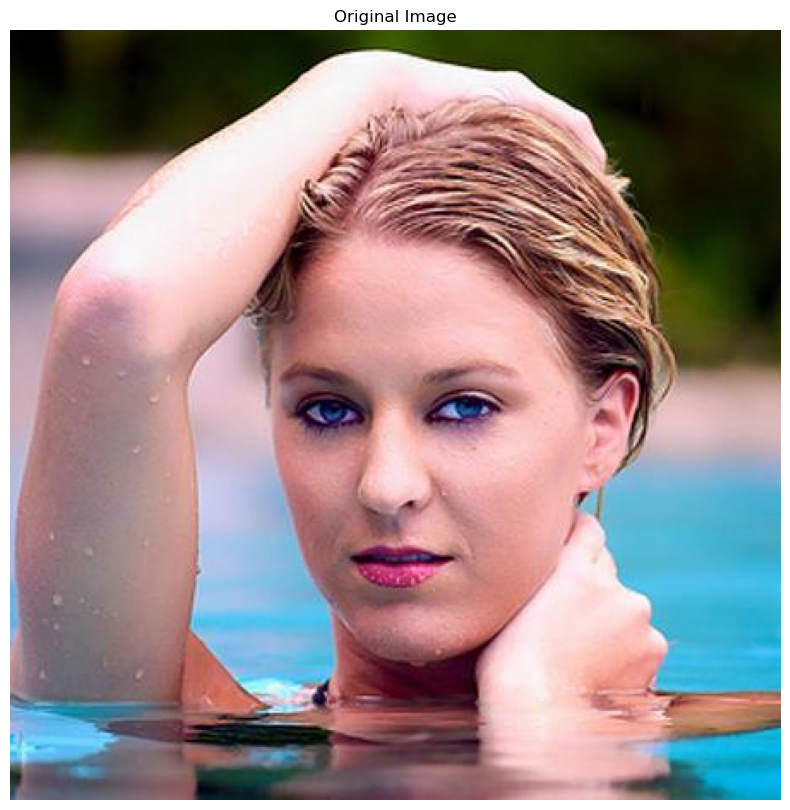

In [37]:
# Load image and pose data
img, pitch, yaw, roll = load_image_and_pose(img_idx, img_dir)
        
# Display the original image
display_image(img, title="Original Image")

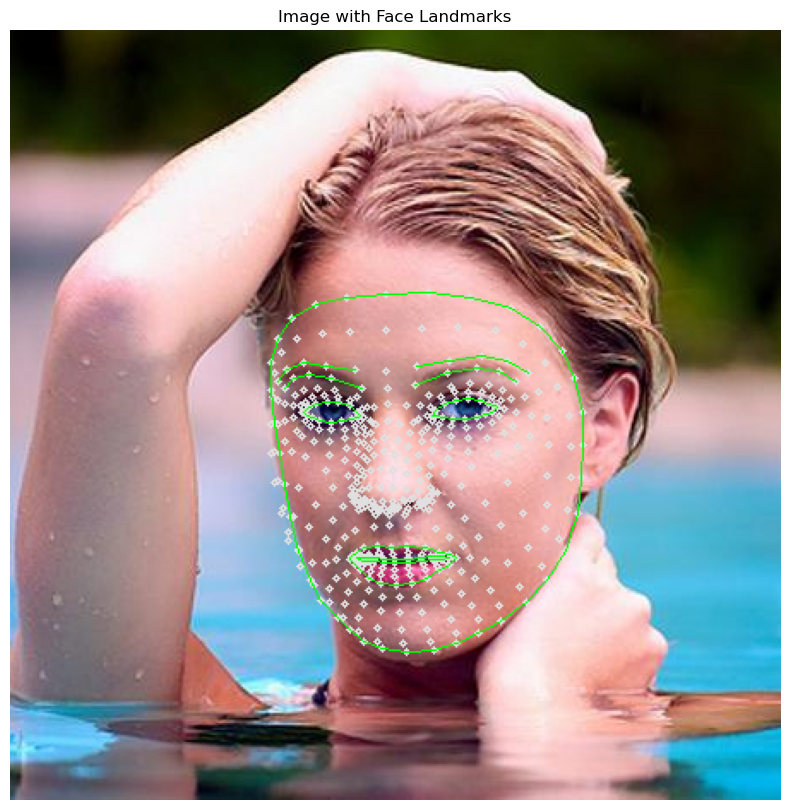

In [38]:
# Detect face landmarks and find nose position
nose_x, nose_y, annotated_img = detect_face_landmarks(img)
        
# Display the image with facial landmarks
display_image(annotated_img, title="Image with Face Landmarks")

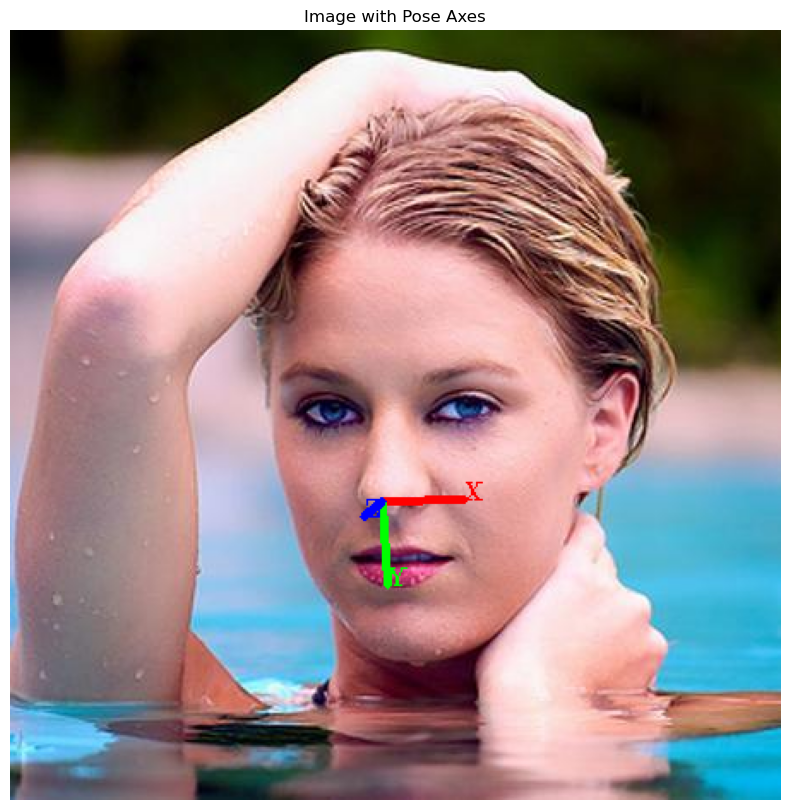

In [39]:
# Draw and display the pose axes on the image
img_with_axes = draw_axes(img, pitch, yaw, roll, nose_x, nose_y, size=50)
display_image(img_with_axes, title="Image with Pose Axes")

## Face Mesh Landmarks Indices
The following dictionary, `FEATURE_INDICES`, defines the indices for specific facial landmarks in the MediaPipe face mesh model. Each landmark corresponds to a unique position on the face.

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*3gRo7_OvpyqN96iO-5O2Lw.png" alt="Face Mesh Example" style="width: 300px;"/>
</div>


In [40]:
# Face mesh landmarks indices
FEATURE_INDICES = {
    "NOSE": 1,
    "FOREHEAD": 10,
    "LEFT_EYE": 33,
    "MOUTH_LEFT": 61,
    "CHIN": 199,
    "RIGHT_EYE": 263,
    "MOUTH_RIGHT": 291
}

## Face Mesh Initialization and Feature Extraction Functions

### Initialize Face Mesh
The `init_face_mesh` function initializes the MediaPipe FaceMesh model with customizable confidence thresholds for detection and tracking.

### Function: Extract Features
The `extract_features` function is designed to extract specific face mesh landmarks from an input image and optionally include head pose angles. This functionality is crucial for applications that require facial analysis and understanding head orientation.

In [41]:
# Initialize FaceMesh with confidence thresholds
def init_face_mesh(min_detection_confidence=0.5, min_tracking_confidence=0.5):
    return mp.solutions.face_mesh.FaceMesh(min_detection_confidence=min_detection_confidence, 
                                           min_tracking_confidence=min_tracking_confidence)

# Extract features from face mesh for the specified image
def extract_features(img, face_mesh, selected_points=FEATURE_INDICES, mat=None):
    """
    Extracts specific face mesh landmarks and optionally head pose angles.

    Parameters:
    - img: Image from which to extract features.
    - face_mesh: Initialized face_mesh object from MediaPipe.
    - selected_points: Dictionary of landmark indices for feature extraction.
    - mat: Optional mat file with Pose_Para to append (pitch, yaw, roll).

    Returns:
    - face_features: List of extracted features, including pose angles if available.
    """
    result = face_mesh.process(img)
    face_features = []

    img_h, img_w = img.shape[:2]

    if result.multi_face_landmarks:
        # Extract specified feature points
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in selected_points.values():
                    face_features.append(lm.x)
                    face_features.append(lm.y)
    else:
        face_features.extend([None] * 14)  # If no face detected, return None values

    # Optionally add pose angles (pitch, yaw, roll) from mat file
    if mat is not None:
        pose_angles = mat['Pose_Para'][0][:3]
        face_features.extend(pose_angles)

    return face_features

# Feature Visualization Function
The `visualize_features` function is designed to annotate an image with extracted feature points. It draws circles at specified coordinates, allowing for effective visualization of the detected landmarksocess visually.


In [42]:
# Visualize extracted feature points on the image
def visualize_features(img, features, img_w, img_h):
    """
    Draws circles at the feature locations on the image for visualization.

    Parameters:
    - img: The input image (RGB format).
    - features: List of x, y coordinates of features.
    - img_w, img_h: Width and height of the image.

    Returns:
    - Annotated image with feature points drawn.
    """
    annot_img = img.copy()

    for i in range(len(features)//2):
        if features[i*2] is not None and features[i*2+1] is not None:
            cv2.circle(annot_img, center=(int(features[i*2]*img_w), int(features[i*2+1]*img_h)), 
                       radius=2, color=(255, 0, 0), thickness=2)
    
    plt.figure(figsize=(20, 10))
    plt.axis('off')
    plt.imshow(annot_img)
    plt.show()


In [43]:
def load_image(image_path):
    """
    Load an image from the given path and convert to RGB format.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - img: Loaded and converted image (RGB format).
    - img_w, img_h: Width and height of the image.
    """
    # Load image using OpenCV
    img = cv2.imread(image_path)
    
    # Convert from BGR (OpenCV default) to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get image dimensions
    img_h, img_w = img.shape[:2]
    
    return img_rgb, img_w, img_h

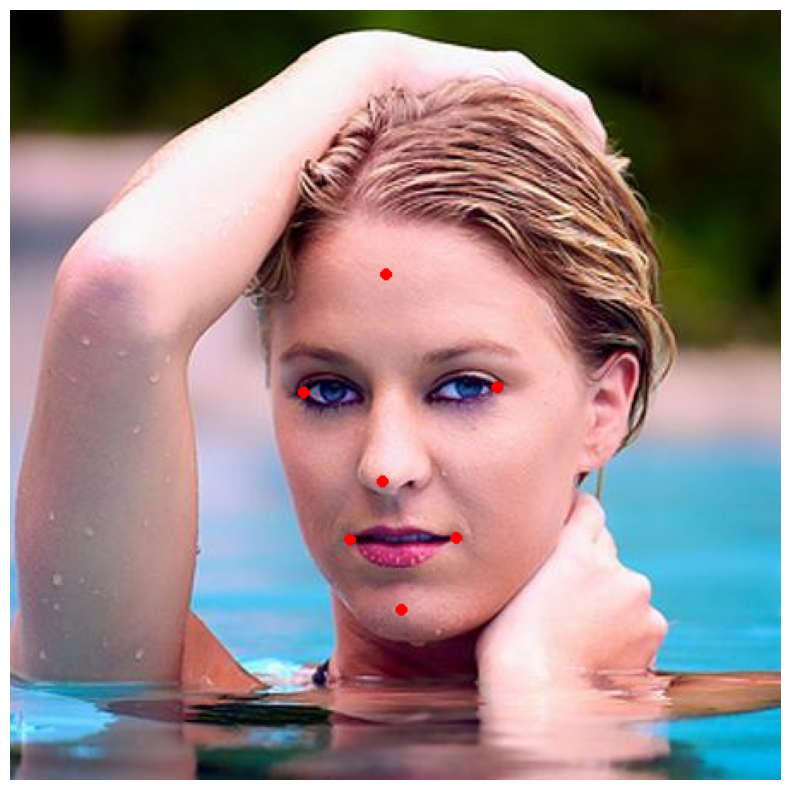

In [44]:

# Load the image
image_path = './data/AFLW2000/image00515.jpg'  # Path to your image
img, img_w, img_h = load_image(image_path)

# Extract features from the image
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Extract features (example of how extract_features might work)
features = extract_features(img, face_mesh)

# Visualize the features
visualize_features(img, features, img_w, img_h)

### Generate Column Names for CSV
The `generate_column_names` function creates a list of column names for the CSV file that will store the extracted feature points and head pose angles. It constructs column names for each facial landmark's x and y coordinates and appends additional columns for the pitch, yaw, and roll pose angles.

In [45]:
# Generate column names for CSV
def generate_column_names():
    """
    Generates column names for feature points (x, y) and pose angles (pitch, yaw, roll).
    
    Returns:
    - List of column names.
    """
    cols = []
    for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
        for dim in ('x', 'y'):
            cols.append(pos + dim)
    cols.extend(['pitch', 'yaw', 'roll'])
    return cols

### Save Extracted Features and Pose Angles to a CSV File
The `save_features_to_csv` function processes a list of images to extract facial features and corresponding head pose angles, then saves the results into a specified CSV file. It iterates through each image path, extracting features using the initialized face mesh model and handling any errors during processing. The extracted data is collected and written to a CSV file, providing a structured format for the dataset.

In [46]:
# Save extracted features and pose angles to a CSV file
def save_features_to_csv(images_paths, img_info_paths, csv_path='./data/poses.csv', face_mesh=None):
    """
    Extracts features and head pose angles for all images in the dataset, 
    and saves the data into a CSV file.

    Parameters:
    - images_paths: List of paths to image files.
    - img_info_paths: List of paths to mat files with pose information.
    - csv_path: Path to save the CSV file.
    - face_mesh: Initialized MediaPipe face mesh model.

    Returns:
    - Saves a CSV file with extracted features.
    """
    # Prepare column names
    cols = generate_column_names()

    # List to hold all the extracted features
    poses = []

    # Iterate through each image and extract features
    for img_idx, img_path in enumerate(images_paths):
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load corresponding .mat file for pose angles
            mat = scipy.io.loadmat(img_info_paths[img_idx])
            face_features = extract_features(img, face_mesh, mat=mat)
            poses.append(face_features)

            # Periodically print status
            if img_idx % 100 == 0:
                print(f'Extracted features from {img_idx} images.')

        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")
            poses.append([None] * 17)  # Add empty row in case of error

    # Convert to DataFrame and save to CSV
    poses_df = pd.DataFrame(poses, columns=cols)
    poses_df.to_csv(csv_path, index=False)
    print(f"Feature data saved to {csv_path}.")

### Initialize MediaPipe FaceMesh
This code snippet initializes the MediaPipe FaceMesh model using the previously defined `init_face_mesh` function. It prepares the model for use in feature extraction from the images in the dataset. The paths for images and corresponding mat files are also loaded using `glob`, ensuring that all relevant data is available for processing.

In [48]:
# Initialize MediaPipe FaceMesh
face_mesh = init_face_mesh()

# Load images and corresponding mat files
images_paths = glob.glob('./data/AFLW2000/*.jpg')
img_info_paths = glob.glob('./data/AFLW2000/*.mat')

print(f'Number of images: {len(images_paths)}')

# Extract and save features to CSV
save_features_to_csv(images_paths, img_info_paths, face_mesh=face_mesh)

Number of images: 2000
Extracted features from 0 images.


C:\Users\Khizar\AppData\Roaming\Python\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Extracted features from 100 images.
Extracted features from 200 images.
Extracted features from 300 images.
Extracted features from 400 images.
Extracted features from 500 images.
Extracted features from 600 images.
Extracted features from 700 images.
Extracted features from 800 images.
Extracted features from 900 images.
Extracted features from 1000 images.
Extracted features from 1100 images.
Extracted features from 1200 images.
Extracted features from 1300 images.
Extracted features from 1400 images.
Extracted features from 1500 images.
Extracted features from 1600 images.
Extracted features from 1700 images.
Extracted features from 1800 images.
Extracted features from 1900 images.
Feature data saved to ./data/poses.csv.


In [49]:
csv_path = './data/poses.csv'  # Path to your CSV file
df = pd.read_csv(csv_path)

In [50]:
print("\nFirst 5 rows of the DataFrame:")
df.head()


First 5 rows of the DataFrame:


,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374


In [51]:
print("\nSummary statistics:")
df.describe(include='all')


Summary statistics:


,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
count,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,2000.000000,2000.000000,2000.000000
mean,0.504462,0.610422,0.501812,0.331433,0.374323,0.488685,0.433001,0.687367,0.507934,0.785988,0.635246,0.484521,0.581381,0.685958,-0.107145,0.014077,-0.034479
std,0.051779,0.026170,0.062493,0.031570,0.038698,0.028571,0.034265,0.022339,0.047238,0.024106,0.038097,0.029168,0.034408,0.022821,0.628119,0.654185,0.716014
min,0.356900,0.495121,0.256226,0.219836,0.279417,0.357461,0.331035,0.610559,0.348678,0.682867,0.509340,0.349354,0.468645,0.564929,-12.457202,-6.130066,-16.969362
25%,0.471445,0.597060,0.464813,0.309133,0.348033,0.470549,0.412340,0.673132,0.482398,0.770899,0.611764,0.465908,0.562807,0.672440,-0.258503,-0.294246,-0.174806
50%,0.502281,0.613624,0.501162,0.329895,0.368740,0.489247,0.430500,0.688357,0.507317,0.788714,0.637781,0.484450,0.583380,0.686948,-0.122268,0.019702,-0.018098
75%,0.535695,0.627649,0.535820,0.351723,0.395603,0.506320,0.450190,0.701879,0.533308,0.802987,0.659050,0.502312,0.601678,0.700561,0.040192,0.334715,0.134378
max,0.862203,0.691136,0.822079,0.470102,0.718541,0.623950,0.799603,0.788673,0.888287,0.883894,0.978258,0.602580,0.949355,0.782472,15.598820,3.277500,5.829394


In [52]:
print("\nMissing values in each column:")
df.isnull().sum()


Missing values in each column:


nose_x           208
nose_y           208
forehead_x       208
forehead_y       208
left_eye_x       208
left_eye_y       208
mouth_left_x     208
mouth_left_y     208
chin_x           208
chin_y           208
right_eye_x      208
right_eye_y      208
mouth_right_x    208
mouth_right_y    208
pitch              0
yaw                0
roll               0
dtype: int64